In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 34 kB/s 
     |████████████████████████████████| 199 kB 58.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=109a05844cd199c571687c06636a4782992ad24fe84c62145abf82808951e2cb
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
spark = SparkSession.builder.appName('test_1').getOrCreate()

In [6]:
df = spark.read.csv('/content/drive/MyDrive/Project/unbalaced_20_80_dataset.csv',inferSchema=True, header=True)

In [7]:
df.show()

+-------+--------------------+--------------+--------+-------------+--------+--------+--------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+------------------+---------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------+------------+-----------+------------------+------------------+-----------+-----------+-----------+--------------------+-------------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------------+-------------------+-----------+-----------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------------+----------------+------------------+--------------+--------------+----------------+

In [8]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Flow ID: string (nullable = true)
 |-- Src IP: string (nullable = true)
 |-- Src Port: integer (nullable = true)
 |-- Dst IP: string (nullable = true)
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: double (nullable = true)
 |-- TotLen Bwd Pkts: double (nullable = true)
 |-- Fwd Pkt Len Max: double (nullable = true)
 |-- Fwd Pkt Len Min: double (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: double (nullable = true)
 |-- Bwd Pkt Len Min: double (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: double (nullable = true)
 |-- Flow Pkts/s: double (nul

In [9]:
df = df.na.drop('any')

In [10]:
df.groupBy('Label').count().show()

+------+-------+
| Label|  count|
+------+-------+
|  ddos|1294524|
|Benign|6292297|
+------+-------+



### Balance:
Benign: 83% - DDOS: 17%

In [11]:
from pyspark.sql.functions import col,isnan, when, count

In [12]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+---+-------+------+--------+------+--------+--------+---------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+----------+----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-

### NO NULLS

In [13]:
df_ddos = df.filter(df['Label']=='ddos')
df_benign = df.filter(df['Label']=='Benign')

In [14]:
oversample_ratio = df_benign.count()/df_ddos.count()

In [15]:
df_ddos_oversampled = df_ddos.sample(withReplacement=True, fraction=oversample_ratio-1, seed=1)

In [16]:
df_final = df_benign.unionAll(df_ddos_oversampled)

In [17]:
df_final.show()

+-------+--------------------+---------------+--------+---------------+--------+--------+--------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+------------------+------------------+---------------+---------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------+------------+------------+------------------+------------------+-----------+-----------+------------+------------------+------------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------------+-------------------+-----------+-----------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------------+------------------+------------------+--------------+--------------+---------

In [18]:
df_final.groupBy('Label').count().show()

+------+-------+
| Label|  count|
+------+-------+
|Benign|6292297|
|  ddos|4999488|
+------+-------+



### Balance: 
Benign: 56% - DDOS: 44% 

In [19]:
df_final.count()

11291785

In [20]:
my_cols_df_full = df_final.columns

In [21]:
my_cols_df_full

['_c0',
 'Flow ID',
 'Src IP',
 'Src Port',
 'Dst IP',
 'Dst Port',
 'Protocol',
 'Timestamp',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Len',
 'Bwd Header Len',
 'Fwd Pkts/s',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size 

In [22]:
df_final.show()

+-------+--------------------+---------------+--------+---------------+--------+--------+--------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+------------------+------------------+---------------+---------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------+------------+------------+------------------+------------------+-----------+-----------+------------+------------------+------------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------------+-------------------+-----------+-----------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------------+------------------+------------------+--------------+--------------+---------

In [23]:
from pyspark.sql.functions import dayofmonth, hour, dayofyear, month, year, weekofyear, format_number, date_format

In [24]:
df_final.select(df_final['Timestamp']).show()

+--------------------+
|           Timestamp|
+--------------------+
| 20/02/2018 10:36:27|
|04/07/2017 12:15:...|
| 20/02/2018 08:55:58|
| 20/02/2018 11:53:46|
| 20/02/2018 10:06:32|
| 20/02/2018 11:28:42|
| 20/02/2018 12:13:16|
| 20/02/2018 10:16:50|
| 20/02/2018 04:22:35|
| 20/02/2018 08:56:55|
| 20/02/2018 10:36:01|
|03/07/2017 06:39:...|
| 20/02/2018 05:10:09|
| 20/02/2018 02:42:50|
|03/07/2017 08:01:...|
| 20/02/2018 10:38:11|
| 20/02/2018 10:01:49|
|04/07/2017 12:25:...|
| 20/02/2018 11:17:24|
| 20/02/2018 02:54:06|
+--------------------+
only showing top 20 rows



In [25]:
df_final.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Flow ID: string (nullable = true)
 |-- Src IP: string (nullable = true)
 |-- Src Port: integer (nullable = true)
 |-- Dst IP: string (nullable = true)
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: double (nullable = true)
 |-- TotLen Bwd Pkts: double (nullable = true)
 |-- Fwd Pkt Len Max: double (nullable = true)
 |-- Fwd Pkt Len Min: double (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: double (nullable = true)
 |-- Bwd Pkt Len Min: double (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: double (nullable = true)
 |-- Flow Pkts/s: double (nul

In [26]:
str_columnList = [item[0] for item in df_final.dtypes if item[1].startswith('string')]

In [27]:
str_columnList

['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'Label']

In [28]:
num_cols = []
for i in df_final.columns:
  if i not in str_columnList:
    num_cols.append(i)

In [29]:
num_cols.append('Label')

In [30]:
df_nums = df_final.select(num_cols)

In [31]:
df_nums.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Src Port: integer (nullable = true)
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: double (nullable = true)
 |-- TotLen Bwd Pkts: double (nullable = true)
 |-- Fwd Pkt Len Max: double (nullable = true)
 |-- Fwd Pkt Len Min: double (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: double (nullable = true)
 |-- Bwd Pkt Len Min: double (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: double (nullable = true)
 |-- Flow Pkts/s: double (nullable = true)
 |-- Flow IAT Mean: double (nullable = true)
 |-- Flow IAT Std: double (nullable = true)
 |-- Flow IAT Max: double (nullable = true)
 |-- Flow

### Building the ML Model

In [32]:
df_nums.show()

+-------+--------+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+------------------+------------------+---------------+---------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------+------------+------------+------------------+------------------+-----------+-----------+------------+------------------+------------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------------+-------------------+-----------+-----------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------------+------------------+------------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+--

In [33]:
from pyspark.ml.feature import VectorAssembler

In [34]:
df_nums.columns

['_c0',
 'Src Port',
 'Dst Port',
 'Protocol',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Len',
 'Bwd Header Len',
 'Fwd Pkts/s',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',


In [35]:
assembler = VectorAssembler(inputCols=df_nums.columns[1:-1], outputCol='features')

In [36]:
output = assembler.transform(df_nums)

In [37]:
from pyspark.ml.feature import StringIndexer

In [38]:
indexer = StringIndexer(inputCol='Label',outputCol='LabelIndex')

In [39]:
output_fixed = indexer.fit(output).transform(output)

In [40]:
output_fixed.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Src Port: integer (nullable = true)
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: double (nullable = true)
 |-- TotLen Bwd Pkts: double (nullable = true)
 |-- Fwd Pkt Len Max: double (nullable = true)
 |-- Fwd Pkt Len Min: double (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: double (nullable = true)
 |-- Bwd Pkt Len Min: double (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: double (nullable = true)
 |-- Flow Pkts/s: double (nullable = true)
 |-- Flow IAT Mean: double (nullable = true)
 |-- Flow IAT Std: double (nullable = true)
 |-- Flow IAT Max: double (nullable = true)
 |-- Flow

In [41]:
output_fixed.show()

+-------+--------+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+------------------+------------------+---------------+---------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------+------------+------------+------------------+------------------+-----------+-----------+------------+------------------+------------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------------+-------------------+-----------+-----------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------------+------------------+------------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+--

In [42]:
final_data = output_fixed.select(['features','LabelIndex'])

In [43]:
final_data.show()

+--------------------+----------+
|            features|LabelIndex|
+--------------------+----------+
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[56889.0,3389.0,6...|       0.0|
|[51263.0,443.0,6....|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,17...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,17...|       0.0|
|[57775.0,3389.0,6...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[49411.0,80.0,6.0...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[52095.0,80.0,6.0...|       0.0|
+--------------------+----------+
only showing top 20 rows



In [44]:
final_data = final_data.na.drop()
final_data.show()

+--------------------+----------+
|            features|LabelIndex|
+--------------------+----------+
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[56889.0,3389.0,6...|       0.0|
|[51263.0,443.0,6....|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,17...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,17...|       0.0|
|[57775.0,3389.0,6...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[49411.0,80.0,6.0...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[52095.0,80.0,6.0...|       0.0|
+--------------------+----------+
only showing top 20 rows



In [45]:
output_fixed.count()

11291785

In [46]:
final_data_2 = final_data.sample(0.001,3)

In [47]:
train_data, test_data = final_data.randomSplit([7.,3.])

### Using Tree Based models and Logistic regression

In [48]:
final_data.show()

+--------------------+----------+
|            features|LabelIndex|
+--------------------+----------+
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[56889.0,3389.0,6...|       0.0|
|[51263.0,443.0,6....|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,17...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,17...|       0.0|
|[57775.0,3389.0,6...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[49411.0,80.0,6.0...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[52095.0,80.0,6.0...|       0.0|
+--------------------+----------+
only showing top 20 rows



In [49]:
train_data.show()

+--------------------+----------+
|            features|LabelIndex|
+--------------------+----------+
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
+--------------------+----------+
only showing top 20 rows



In [50]:
test_data.show()

+--------------------+----------+
|            features|LabelIndex|
+--------------------+----------+
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
+--------------------+----------+
only showing top 20 rows



In [51]:
train_data.groupBy('LabelIndex').count().show()

+----------+-------+
|LabelIndex|  count|
+----------+-------+
|       0.0|4403593|
|       1.0|3499946|
+----------+-------+



In [52]:
test_data.groupBy('LabelIndex').count().show()

+----------+-------+
|LabelIndex|  count|
+----------+-------+
|       0.0|1888704|
|       1.0|1499542|
+----------+-------+



In [53]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, LogisticRegression

In [54]:
dt = DecisionTreeClassifier(labelCol='LabelIndex',featuresCol='features')
rf = RandomForestClassifier(numTrees=100,labelCol='LabelIndex',featuresCol='features')
gbt = GBTClassifier(labelCol='LabelIndex',featuresCol='features')

In [55]:
#gpu_info = !nvidia-smi
#gpu_info = '\n'.join(gpu_info)
#if gpu_info.find('failed') >= 0:
#  print('Not connected to a GPU')
#else:
#  print(gpu_info)

In [59]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


### 1) Decision Tree

In [58]:
#dt_model = dt.fit(train_data)

In [61]:
#rf_model = rf.fit(df_train)
#gb_model = gbt.fit(df_train)

In [62]:
#dt_preds = dt_model.transform(test_data)

In [63]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [64]:
my_binary_eval = BinaryClassificationEvaluator(labelCol='LabelIndex')

In [65]:
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="LabelIndex", predictionCol="prediction")

In [66]:
#acc_dt = evaluatorMulti.evaluate(dt_preds, {evaluatorMulti.metricName: "accuracy"})

In [67]:
#acc_dt

In [68]:
#auc_dt = my_binary_eval.evaluate(dt_preds)

In [69]:
#auc_dt

In [70]:
#f1_dt = evaluatorMulti.evaluate(dt_preds, {evaluatorMulti.metricName: "f1"})
#f1_dt

In [71]:
#dt_preds.show()

### 2) Random Forest

In [72]:
rf_model = rf.fit(train_data)
rf_preds = rf_model.transform(test_data)
acc_rf = evaluatorMulti.evaluate(rf_preds, {evaluatorMulti.metricName: "accuracy"})
auc_rf = my_binary_eval.evaluate(rf_preds)
f1_rf = evaluatorMulti.evaluate(rf_preds, {evaluatorMulti.metricName: "f1"})
print('\n')
print(f"accuracy: {acc_rf}")
print('\n')
print(f"auc score: {auc_rf}")
print('\n')
print(f"f1-score: {f1_rf}")



accuracy: 0.9907754631747517


auc score: 0.9994166128435829


f1-score: 0.9907769331165337


In [73]:
rf_preds.show()

+--------------------+----------+--------------------+--------------------+----------+
|            features|LabelIndex|       rawPrediction|         probability|prediction|
+--------------------+----------+--------------------+--------------------+----------+
|(79,[0,1,2,3,4,5,...|       0.0|[96.6547085537761...|[0.96654708553776...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[99.6066181655958...|[0.99606618165595...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[93.4320938294347...|[0.93432093829434...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[98.6666401086789...|[0.98666640108678...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[98.4373170460185...|[0.98437317046018...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[98.4373170460185...|[0.98437317046018...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[98.6289187773352...|[0.98628918777335...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[97.6000349817295...|[0.97600034981729...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[95.732979

In [74]:
rf_model.featureImportances

SparseVector(79, {0: 0.0257, 1: 0.0259, 2: 0.0117, 3: 0.0149, 4: 0.0178, 5: 0.004, 6: 0.0194, 7: 0.0021, 8: 0.0341, 9: 0.0093, 10: 0.0252, 11: 0.0317, 12: 0.0024, 13: 0.024, 14: 0.0046, 15: 0.0042, 16: 0.0034, 17: 0.02, 18: 0.0092, 19: 0.0014, 20: 0.0131, 21: 0.0159, 22: 0.0071, 23: 0.0112, 24: 0.0069, 25: 0.0086, 26: 0.0048, 27: 0.0028, 28: 0.0006, 29: 0.0035, 30: 0.0013, 31: 0.0015, 32: 0.0, 33: 0.0001, 36: 0.0292, 37: 0.0316, 38: 0.0133, 39: 0.0103, 40: 0.0146, 41: 0.0131, 42: 0.0079, 43: 0.0106, 44: 0.0044, 45: 0.0006, 46: 0.0037, 47: 0.0001, 48: 0.0154, 49: 0.0219, 50: 0.0016, 51: 0.0022, 52: 0.0025, 53: 0.0034, 54: 0.007, 55: 0.0533, 56: 0.0017, 63: 0.0292, 64: 0.0225, 65: 0.0111, 66: 0.008, 67: 0.0595, 68: 0.0381, 69: 0.009, 70: 0.1997, 71: 0.0, 72: 0.0, 73: 0.0003, 74: 0.0002, 75: 0.0016, 76: 0.0004, 77: 0.0022, 78: 0.0013})

In [75]:
df_nums.columns[1:-1]

['Src Port',
 'Dst Port',
 'Protocol',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Len',
 'Bwd Header Len',
 'Fwd Pkts/s',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Fwd By

In [76]:
len(df_nums.columns[1:-1])

79

In [77]:
len(rf_model.featureImportances)

79

In [78]:
cols_name = df_nums.columns[1:-1]

In [79]:
feature_importance = []
for i in rf_model.featureImportances:
  feature_importance.append(i)

In [80]:
df_feat_imp = pd.DataFrame({'Feature Name': cols_name, 'Feature Importance':feature_importance})

In [81]:
df_feat_imp.index = df_feat_imp['Feature Name']

In [82]:
df_feat_imp.drop('Feature Name',inplace=True,axis=1)

In [83]:
df_feat_imp.sort_values(by='Feature Importance',ascending=False).head(20)

,Feature Importance
Feature Name,
Fwd Seg Size Min,0.199724
Init Fwd Win Byts,0.059508
Fwd Seg Size Avg,0.053329
Init Bwd Win Byts,0.038060
Fwd Pkt Len Max,0.034139
Fwd Pkt Len Std,0.031652
Bwd Header Len,0.031592
Fwd Header Len,0.029226
Subflow Fwd Pkts,0.029157


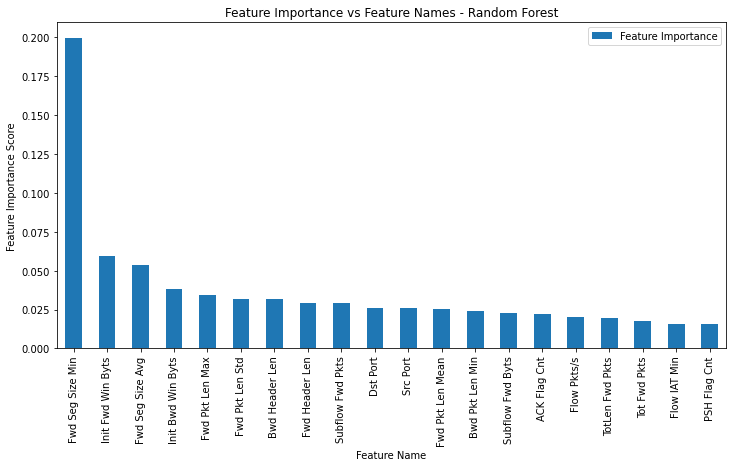

In [84]:
df_feat_imp.sort_values(by='Feature Importance',ascending=False).head(20).plot(kind='bar',figsize=(12,6))
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance Score')
plt.title('Feature Importance vs Feature Names - Random Forest')
plt.show();